In [8]:
import pandas as pd

def process_txt_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for i in range(0, len(lines), 3):
            filename = lines[i].split("'")[1]
            energy = float(lines[i+2].split(": ")[1])
            parts = filename.split('_')
            distribution = parts[1]
            frequency = parts[2]
            id_number = int(parts[-2])
            if 1 <= id_number <= 60:
                granularity = 'coarse'
            elif 61 <= id_number <= 120:
                granularity = 'medium'
            elif 121 <= id_number <= 180:
                granularity = 'fine'
            else:
                granularity = 'unknown'

            data.append({
                'filename': filename,
                'granularity': granularity,
                'distribution': distribution,
                'frequency': frequency,
                'energy_consumption': energy,
                'id_number': id_number
            })

    return pd.DataFrame(data)

train_df = process_txt_file('../processed_data/energy_train.txt')
pet_df = process_txt_file('../processed_data/energy_pet.txt')
for name, df in [("Train Ticket System", train_df), ("Pet Clinic System", pet_df)]:
    print(f"\n{name} Data:")
    print(df.groupby(['granularity', 'distribution', 'frequency']).size().unstack(fill_value=0))
    print("\nSample data:")
    print(df.head())

train_df.to_csv('processed_train_energy.csv', index=False)
pet_df.to_csv('processed_pet_energy.csv', index=False)


Train Ticket System Data:
frequency                 high  low  low60  med
granularity distribution                       
coarse      burst           30   30      0   30
            even            30   20     10   30

Sample data:
                                            filename granularity distribution  \
0  locustfile_burst_high_0.01_80_40_10s_1_request...      coarse        burst   
1  locustfile_burst_high_0.01_80_40_10s_2_request...      coarse        burst   
2  locustfile_burst_high_0.01_80_40_10s_3_request...      coarse        burst   
3  locustfile_burst_high_0.01_80_40_10s_4_request...      coarse        burst   
4  locustfile_burst_high_0.01_80_40_10s_5_request...      coarse        burst   

  frequency  energy_consumption  id_number  
0      high              395.68          1  
1      high              390.70          2  
2      high              371.42          3  
3      high              363.29          4  
4      high              376.11          5  

Pet Clini

Train Ticket System - Granularity: coarse
Shapiro-Wilk test - Statistics: 0.8033, p-value: 1.637833975504612e-07
Train Ticket System - Granularity: medium
Shapiro-Wilk test - Statistics: 0.8253, p-value: 6.110158228400273e-07
Train Ticket System - Granularity: fine
Shapiro-Wilk test - Statistics: 0.8280, p-value: 7.255518204667839e-07


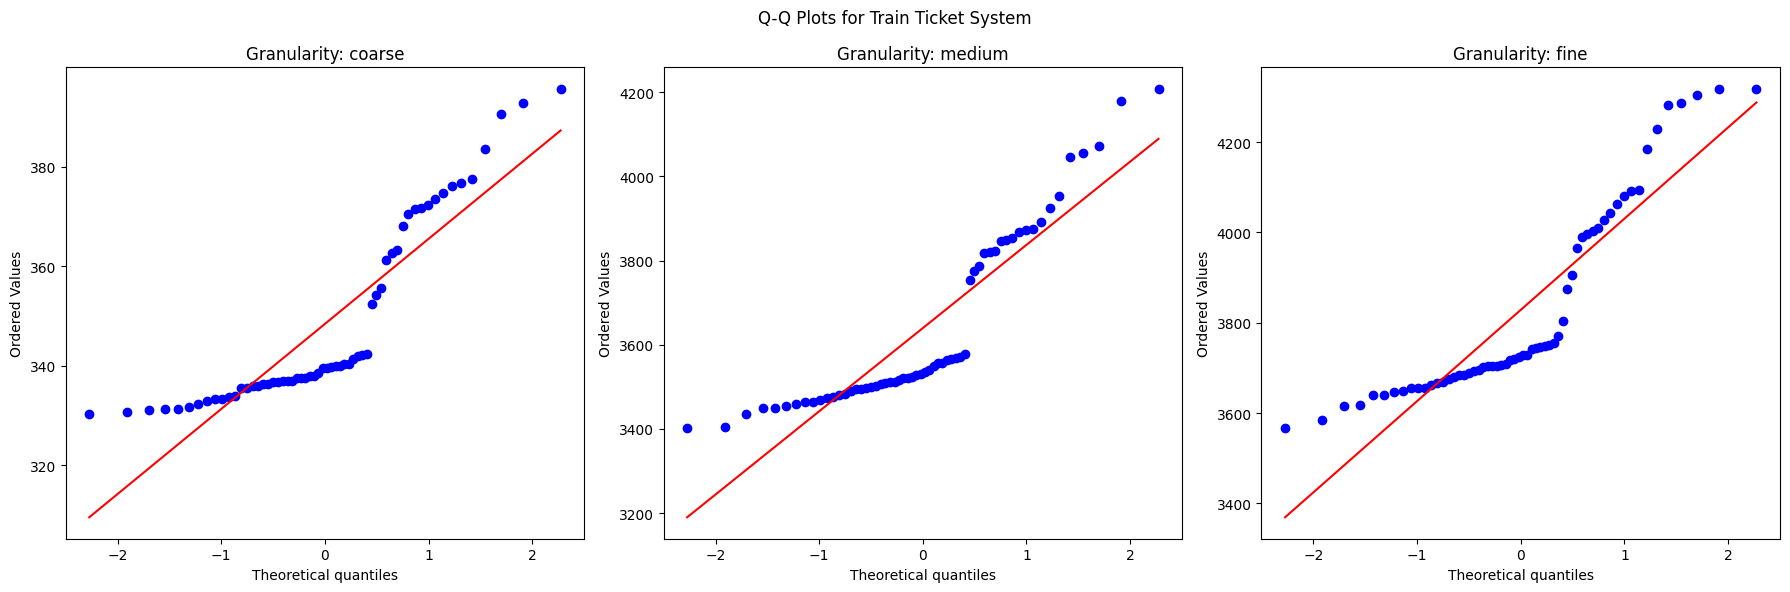

Pet Clinic System - Granularity: coarse
Shapiro-Wilk test - Statistics: 0.8923, p-value: 6.983064054600377e-05
Pet Clinic System - Granularity: medium
Shapiro-Wilk test - Statistics: 0.7310, p-value: 3.6830883303199995e-09
Pet Clinic System - Granularity: fine
Shapiro-Wilk test - Statistics: 0.7151, p-value: 1.7569663235963707e-09


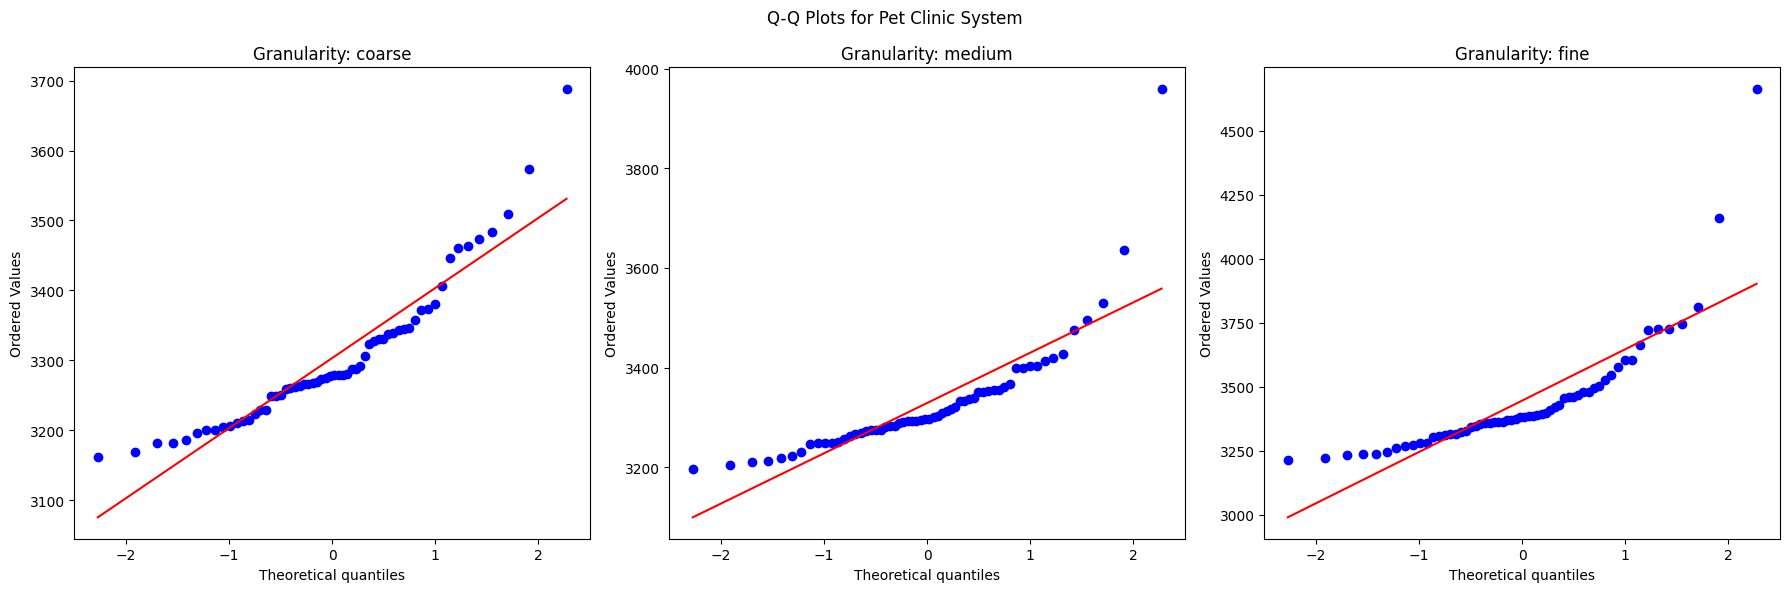

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def normality_check(data, system_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Q-Q Plots for {system_name}")

    for i, granularity in enumerate(['coarse', 'medium', 'fine']):
        subset = data[data['granularity'] == granularity]['energy_consumption']

        # Shapiro-Wilk test
        stat, p = stats.shapiro(subset)
        print(f"{system_name} - Granularity: {granularity}")
        print(f"Shapiro-Wilk test - Statistics: {stat:.4f}, p-value: {p}")

        # Q-Q plot
        stats.probplot(subset, dist="norm", plot=axes[i])
        axes[i].set_title(f"Granularity: {granularity}")

    plt.tight_layout()
    plt.show()

# Load the corrected data
train_df = pd.read_csv('corrected_train_energy.csv')
pet_df = pd.read_csv('corrected_pet_energy.csv')

# Perform normality check for each system
for system, df in [("Train Ticket System", train_df), ("Pet Clinic System", pet_df)]:
    normality_check(df, system)

In [16]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# Load the data
pet_df = pd.read_csv('corrected_pet_energy.csv')
train_df = pd.read_csv('corrected_train_energy.csv')

def non_parametric_analysis(df, system_name):
    # Kruskal-Wallis H-test
    coarse = df[df['granularity'] == 'coarse']['energy_consumption']
    medium = df[df['granularity'] == 'medium']['energy_consumption']
    fine = df[df['granularity'] == 'fine']['energy_consumption']

    h_statistic, p_value = stats.kruskal(coarse, medium, fine)

    print(f"{system_name} - Kruskal-Wallis H-test:")
    print(f"H-statistic: {h_statistic:.4f}, p-value: {p_value:.4f}")
    # Post-hoc pairwise comparisons using Mann-Whitney U test
    pairs = [('coarse', 'medium'), ('coarse', 'fine'), ('medium', 'fine')]
    for pair in pairs:
        stat, p = stats.mannwhitneyu(df[df['granularity'] == pair[0]]['energy_consumption'],
                                     df[df['granularity'] == pair[1]]['energy_consumption'])
        print(f"{pair[0]} vs {pair[1]}: U-statistic = {stat:.4f}, p-value = {p:.4f}")



# Perform analysis for both systems
for name, dataframe in [("Pet Clinic System", pet_df), ("Train Ticket System", train_df)]:
    print(f"\nAnalysis for {name}")
    non_parametric_analysis(dataframe, name)


Analysis for Pet Clinic System
Pet Clinic System - Kruskal-Wallis H-test:
H-statistic: 29.6441, p-value: 0.0000
coarse vs medium: U-statistic = 1463.5000, p-value = 0.0778
coarse vs fine: U-statistic = 849.0000, p-value = 0.0000
medium vs fine: U-statistic = 1025.0000, p-value = 0.0000

Analysis for Train Ticket System
Train Ticket System - Kruskal-Wallis H-test:
H-statistic: 130.2085, p-value: 0.0000
coarse vs medium: U-statistic = 0.0000, p-value = 0.0000
coarse vs fine: U-statistic = 0.0000, p-value = 0.0000
medium vs fine: U-statistic = 859.0000, p-value = 0.0000


In [18]:
def cliffs_delta(group1, group2):
    n1 = len(group1)
    n2 = len(group2)

    dominance = 0
    for i in group1:
        for j in group2:
            if i > j:
                dominance += 1
            elif i < j:
                dominance -= 1

    return dominance / (n1 * n2)

def interpret_cliffs_delta(d):
    if abs(d) < 0.147:
        return "Negligible"
    elif abs(d) < 0.33:
        return "Small"
    elif abs(d) < 0.474:
        return "Medium"
    else:
        return "Large"

In [25]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests

def non_parametric_analysis(df, system_name):
    # Kruskal-Wallis H-test
    coarse = df[df['granularity'] == 'coarse']['energy_consumption']
    medium = df[df['granularity'] == 'medium']['energy_consumption']
    fine = df[df['granularity'] == 'fine']['energy_consumption']
    h_statistic, p_value = stats.kruskal(coarse, medium, fine)
    print(f"{system_name} - Kruskal-Wallis H-test:")
    print(f"H-statistic: {h_statistic:.4f}, p-value: {p_value:.4f}")

    # Post-hoc pairwise comparisons using Mann-Whitney U test and Cliff's Delta
    pairs = [('coarse', 'medium'), ('coarse', 'fine'), ('medium', 'fine')]
    p_values = []
    results = []

    for pair in pairs:
        group1 = df[df['granularity'] == pair[0]]['energy_consumption']
        group2 = df[df['granularity'] == pair[1]]['energy_consumption']
        stat, p = stats.mannwhitneyu(group1, group2)
        delta = cliffs_delta(group1, group2)
        effect_size = interpret_cliffs_delta(delta)
        p_values.append(p)
        results.append((pair, stat, p, delta, effect_size))

    # Holm-Bonferroni correction
    reject, p_adjusted, _, _ = multipletests(p_values, method='holm')

    # Calculate adjusted alpha levels
    n = len(p_values)
    alpha = 0.05  # You can change this to your desired significance level
    adjusted_alphas = [alpha / (n - i) for i in range(n)]

    for (pair, stat, p, delta, effect_size), p_adj, adj_alpha in zip(results, p_adjusted, adjusted_alphas):
        print(f"{pair[0]} vs {pair[1]}:")
        print(f" Mann-Whitney U-test: U-statistic = {stat:.4f}, p-value = {p:.4f}")
        print(f" Holm-Bonferroni adjusted p-value = {p_adj:.4f}")
        print(f" Holm-Bonferroni adjusted alpha = {adj_alpha:.4f}")
        print(f" Cliff's Delta: {delta:.4f} ({effect_size} effect)")

# Load the data
pet_df = pd.read_csv('corrected_pet_energy.csv')
train_df = pd.read_csv('corrected_train_energy.csv')

# Perform analysis for both systems
for name, dataframe in [("Pet Clinic System", pet_df), ("Train Ticket System", train_df)]:
    print(f"\nAnalysis for {name}")
    non_parametric_analysis(dataframe, name)


Analysis for Pet Clinic System
Pet Clinic System - Kruskal-Wallis H-test:
H-statistic: 29.6441, p-value: 0.0000
coarse vs medium:
 Mann-Whitney U-test: U-statistic = 1463.5000, p-value = 0.0778
 Holm-Bonferroni adjusted p-value = 0.0778
 Holm-Bonferroni adjusted alpha = 0.0167
 Cliff's Delta: -0.1869 (Small effect)
coarse vs fine:
 Mann-Whitney U-test: U-statistic = 849.0000, p-value = 0.0000
 Holm-Bonferroni adjusted p-value = 0.0000
 Holm-Bonferroni adjusted alpha = 0.0250
 Cliff's Delta: -0.5283 (Large effect)
medium vs fine:
 Mann-Whitney U-test: U-statistic = 1025.0000, p-value = 0.0000
 Holm-Bonferroni adjusted p-value = 0.0001
 Holm-Bonferroni adjusted alpha = 0.0500
 Cliff's Delta: -0.4306 (Medium effect)

Analysis for Train Ticket System
Train Ticket System - Kruskal-Wallis H-test:
H-statistic: 130.2085, p-value: 0.0000
coarse vs medium:
 Mann-Whitney U-test: U-statistic = 0.0000, p-value = 0.0000
 Holm-Bonferroni adjusted p-value = 0.0000
 Holm-Bonferroni adjusted alpha = 0.

In [21]:
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def build_linear_regression(df, system_name):
    X = df[['granularity', 'distribution', 'frequency']]
    y = df['energy_consumption']

    ct = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), ['granularity', 'distribution', 'frequency'])], remainder='passthrough')
    X_encoded = ct.fit_transform(X)
    feature_names = ct.get_feature_names_out(['granularity', 'distribution', 'frequency'])
    model = LinearRegression()
    model.fit(X_encoded, y)
    y_pred = model.predict(X_encoded)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)

    print(f"\nLinear Regression Results for {system_name}")
    print(f"R-squared: {r2:.4f}")
    print(f"Mean Squared Error: {mse:.4f}")

    X_with_constant = sm.add_constant(X_encoded)
    model_sm = sm.OLS(y, X_with_constant).fit()
    print("\nDetailed Statistics:")
    print(model_sm.summary())
    coefficients = model_sm.params[1:]
    for name, coef in zip(feature_names, coefficients):
        print(f"{name}: {coef:.4f}")

pet_df = pd.read_csv('corrected_pet_energy.csv')
train_df = pd.read_csv('corrected_train_energy.csv')
for name, dataframe in [("Pet Clinic System", pet_df), ("Train Ticket System", train_df)]:
    build_linear_regression(dataframe, name)


Linear Regression Results for Pet Clinic System
R-squared: 0.4866
Mean Squared Error: 15335.5594

Detailed Statistics:
                            OLS Regression Results                            
Dep. Variable:     energy_consumption   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     32.98
Date:                Mon, 05 Aug 2024   Prob (F-statistic):           1.40e-23
Time:                        16:01:29   Log-Likelihood:                -1122.8
No. Observations:                 180   AIC:                             2258.
Df Residuals:                     174   BIC:                             2277.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [31]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

def build_linear_regression_with_holm_bonferroni(df):
    X = df[['granularity', 'distribution', 'frequency', 'system']]
    y = df['energy_consumption']

    ct = ColumnTransformer([('encoder', OneHotEncoder(drop='first'), ['granularity', 'distribution', 'frequency', 'system'])], remainder='passthrough')
    X_encoded = ct.fit_transform(X)
    feature_names = ct.get_feature_names_out(['granularity', 'distribution', 'frequency', 'system'])
    X_with_constant = sm.add_constant(X_encoded)
    model = sm.OLS(y, X_with_constant).fit()

    print(f"\nLinear Regression Results")
    print(f"R-squared: {model.rsquared:.4f}")
    print(f"Adjusted R-squared: {model.rsquared_adj:.4f}")
    p_values = model.pvalues[1:]
    coefficients = model.params[1:]

    reject, p_corrected, _, _ = multipletests(p_values, method='holm')

    print("\nHolm-Bonferroni Corrected Results:")
    for name, coef, p, p_corr, rej in zip(feature_names, coefficients, p_values, p_corrected, reject):
        significance = "significant" if rej else "not significant"
        print(f"{name}: coefficient = {coef:.4f}, original p-value = {p:.4f}, "
              f"corrected p-value = {p_corr:.4f}, {significance}")

    print("\nModel Summary:")
    print(model.summary())

pet_df = pd.read_csv('corrected_pet_energy.csv')
pet_df['system'] = "pet"
train_df = pd.read_csv('corrected_train_energy.csv')
train_df['system'] = "train"

combined_df = pd.concat([pet_df, train_df])

build_linear_regression_with_holm_bonferroni(combined_df)



Linear Regression Results
R-squared: 0.5721
Adjusted R-squared: 0.5649

Holm-Bonferroni Corrected Results:
encoder__granularity_fine: coefficient = 1811.5608, original p-value = 0.0000, corrected p-value = 0.0000, significant
encoder__granularity_medium: coefficient = 1658.3075, original p-value = 0.0000, corrected p-value = 0.0000, significant
encoder__distribution_even: coefficient = -11.2282, original p-value = 0.8935, corrected p-value = 0.8935, not significant
encoder__frequency_low: coefficient = -266.4741, original p-value = 0.0098, corrected p-value = 0.0295, significant
encoder__frequency_med: coefficient = -229.6978, original p-value = 0.0259, corrected p-value = 0.0517, not significant
encoder__system_train: coefficient = -754.0217, original p-value = 0.0000, corrected p-value = 0.0000, significant

Model Summary:
                            OLS Regression Results                            
Dep. Variable:     energy_consumption   R-squared:                       0.572
Mode